<a href="https://colab.research.google.com/github/annkristinbalve/Process-centric-gp_tutorial/blob/main/tutorial_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process-Centric Gaussian Processes - Interactive Tutorial
#### Ann-Kristin Balve
##### Supervisor: Professor Carl Edward Rasmussen
##### Department of Engineering, University of Cambridge

## Introduction

This tutorial introduces a new, conceptually easier framework for Gaussian Processes (GPs) - the 'process-centric' view - which helps developing an intuition of what GPs are.  According to this view, a GP is an object that is specified by a mean and covariance function and allows only two main operations: conditioning and operation. You will understand at the end of this tutorial exactly what this means.
First we import the necessary packages and load the data.

<div class="alert alert-block alert-danger"><b>Note:</b> We will use <em>plotly</em>, <em>nbconvert</em>, and <em>ipywidgets</em> to create an interactive tutorial. To make sure that the notebook runs without errors, make sure that you have the following package versions installed.
</div>

The tutorial contains definitions (green boxes), interactive visualisations, accompanied by explanations (grey boxes), as well as mathematical formulations and pseudo code.

In [1]:
# ## Uncomment the following to clone all necessary modules from Github and install the correct package versions.
# !pip install plotly==5.10
# !pip install ipywidgets==8.1.3

# !rm -rf Process-centric-gp_tutorial
# !git clone https://github.com/annkristinbalve/Process-centric-gp_tutorial.git
# %cd Process-centric-gp_tutorial

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Cloning into 'Process-centric-gp_tutorial'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/7

In [2]:
## Importing all necessary packages
import numpy as np
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal, norm
from scipy.spatial.distance import cdist
import math
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox, Layout
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Bivariate Gaussian Distribution

Gaussian Processes rely on multivariate Gaussian distributions and it's properties.

<div class="alert alert-block alert-success"><b>Gaussian Distribution: A continuous probability distribution for a real-valued random variable, fully specified by a mean and covariance.

$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{D/2}|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)
$

</div>

In the following plot, we will explore a 3D plot of a the bivariate Gaussian distribution, a Gaussian distribution for two jointly random variables.
The bivariate Gaussian is specified by a 2 x 1 mean vector $\mu$ and a 2 x 2 covariance matrix $\Sigma$. We also plot the marginal distributions in red and blue. Samples drawn from this multivariate distribution are shown as black dots.


In [3]:
from visualisations import plot_multivariate_Gaussian_3d
## adjust mean and cov to change the mean vector and covariance matrix
mean = [0, 0]
cov_xy = 0.9
cov = np.array([[1, cov_xy], [cov_xy, 1]])
plot_multivariate_Gaussian_3d(mean, cov)

<div class="alert alert-block alert-info"><b>Plot Details:</b> The plot can be rendered by mouse interaction.
</div>

Before we move to Gaussian processes, we will explore the two main properties of Gaussian processes - Closure under marginalisation and closure under conditioning.

### Property I of Gaussians: The Marginalisation Property

The marginalisation property ensures that we obtain a finite dimensional object which we can visualise and work with. For example for a bivariate Gaussian, $x_1$ and $x_2$ are jointly Gaussian, we can obtain the parameters of the marginal distribution of $x_1$ by simply ignoring contributions of random variables we are not interested in. Marginalisation of a Gaussian results in another Gaussian, thus the distribution is closed under marginalisation.

$$
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}
m_1 \\
m_2
\end{bmatrix}, \begin{bmatrix}
\sigma_1^2 & c \\
c & \sigma_2^2
\end{bmatrix}\right) \implies x_1 \sim \mathcal{N}(m_1, \sigma_1^2).
$$




In [4]:
from visualisations import plot_multivariate_Gaussian_2d

def update(mean_x, mean_y, cov_xy):
    mean = [mean_x, mean_y]
    cov = np.array([[1, cov_xy], [cov_xy, 1]])
    plot_multivariate_Gaussian_2d(mean,cov)

mean_x_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.5, description='Mean (m1)')
mean_y_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.5, description='Mean (m2)')
cov_xy_slider = widgets.FloatSlider(value=0, min=0, max=0.9, step=0.25, description='Cov(x1x2) = c')

interactive_plot = interactive(update, mean_x=mean_x_slider, mean_y=mean_y_slider, cov_xy=cov_xy_slider)
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='Mean (m1)', max=3.0, min=-3.0, step=0.5), FloatSlide…

<div class="alert alert-block alert-info"><b>Plot Details:</b> We can see that adjusting the means, but not the covariance, changes the marginal distributions. However, changing the covariance adjusts the shape of the distribution. The eigenvectors of the joint distribution indicate the direction of spread.
</div>

### Property II of Gaussians: Conditioning Property
Conditioning is used to update our knowledge based on knowing the value of one variable. Conditioning a Gaussian distribution results in another Gaussian. Thus, the Gaussian distribution is closed under marginalisation. For a bivariate Gaussian we use:

$$
p(x_1 | x_2) = \mathcal{N} \left( m_1 + c\sigma_2^{-2} (x_2 - m_2), \sigma_1^2 - c\sigma_2^{-2}c^\top \right).
$$

The next visualisation allows to explore specifically the effects of changing a specific y value x is conditioned on as well as the covariance. You can play around with both parameters using sliders.

In [5]:
def update(x2_value, cov_xy):
    mean = [0, 0]
    cov = np.array([[1, cov_xy], [cov_xy, 1]])
    plot_multivariate_Gaussian_2d(mean, cov, x2_value)

x2_slider = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.5, description='X2 value')
cov_xy_slider = widgets.FloatSlider(value=0.5, min=0, max=0.9, step=0.5, description='Cov(x1x2) = c')

interactive_plot = interactive(update, x2_value=x2_slider, cov_xy=cov_xy_slider)
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='X2 value', max=2.0, min=-2.0, step=0.5), FloatSlider…

<div class="alert alert-block alert-info"><b>Plot Details:</b> We can see that increasing the joint covariance decreases the conditional variance which also follows from the above formula. Changing the value of y changes the conditional mean.  
</div>

## Process-Centric Gaussian Processes

Gaussian Processes are a special type of stochastic process, where every finite collection of its random variables has a multivariate Gaussian distribution.

$$
\mathcal{N}(\text{f} | \text{m}, \text{k})
 \ \ \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma_n^2 \mathbf{I})\  \ = \ \
 Z_{\vert \mathbf{y}}  \ \
 \mathcal{N}(\text{f} \vert  \text{m}_{\vert \mathbf{y}}, \text{k}_{\vert \mathbf{y}}),
$$

where

$$
\text{m}_{\vert \mathbf{y}}(\text{x}) = \text{m}(\text{x}) + \text{k}(\text{x}, \mathbf{x})[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1}(\mathbf{y} - \mathbf{m}),
$$

$$
\text{k}_{\vert \mathbf{y}}(\text{x}, \text{x'}) = \text{k}(\text{x}, \text{x'}) - \text{k}(\text{x}, \mathbf{x})[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1} \text{k}(\mathbf{x}, \text{x'}),
$$

$$
Z_{\vert \mathbf{y}} = \mathcal{N}(\mathbf{y} \mid \mathbf{m}, \mathbf{K} + \sigma_n^2 \mathbf{I}).
$$


<div class="alert alert-block alert-success">
    <b>Stochastic Process:</b> A collection of random variables {𝑋(𝑡):𝑡∈𝑇} indexed by parameter t, used to model systems that occur in a random manner.
</div>

<div class="alert alert-block alert-success">
    <b>According to the process-centric view on GPs</b> a GP is an object specified by a mean and covariance function and allows two main operations: marginalisation and conditioning.
</div>


### Prior Gaussian Process
Now, we can look at different covariance and mean functions. For better visualisation, we draw samples from a GP Prior using the following algorithm:


<div style="text-align: center;">
<img src="attachment:2ad2dfe1-48d9-445b-a29a-069094944671.png" width="350"/>
</div>

#### Prior Mean Functions

The mean function \( m(x) \) represents the average behavior of the Gaussian process when drawing many samples.

$$
m(\textbf{x}) = \mathbb{E}[f(\textbf{x})]
$$

The default and most commonly used mean function is the zero mean function implying that the data has zero mean. However, if we assume underlying data trends, we can incorporate that knowledge into our model by specifying a non-zero mean function. A choice of mean functions can be found in the _means.py_ file, including:

| **Mean Function** | **Formula**                          | **Description**                                       |
|-------------------|--------------------------------------|-------------------------------------------------------|
| Zero Mean         |  $$m(x) = 0       $$               | A zero mean function implies that the data has zero mean. |
| Linear Mean       |$$  m(x) = x        $$               | Models linear data trends.                            |
| Periodic Mean     |  $$m(x) = sin(x)      $$           | Can model periodic patterns.                          |
| Step Mean         | $$ m(x) = $\mathbb{1}(x > 0)$$     | Models step changes.                                  |


In the following, we draw ten samples using these four mean functions.

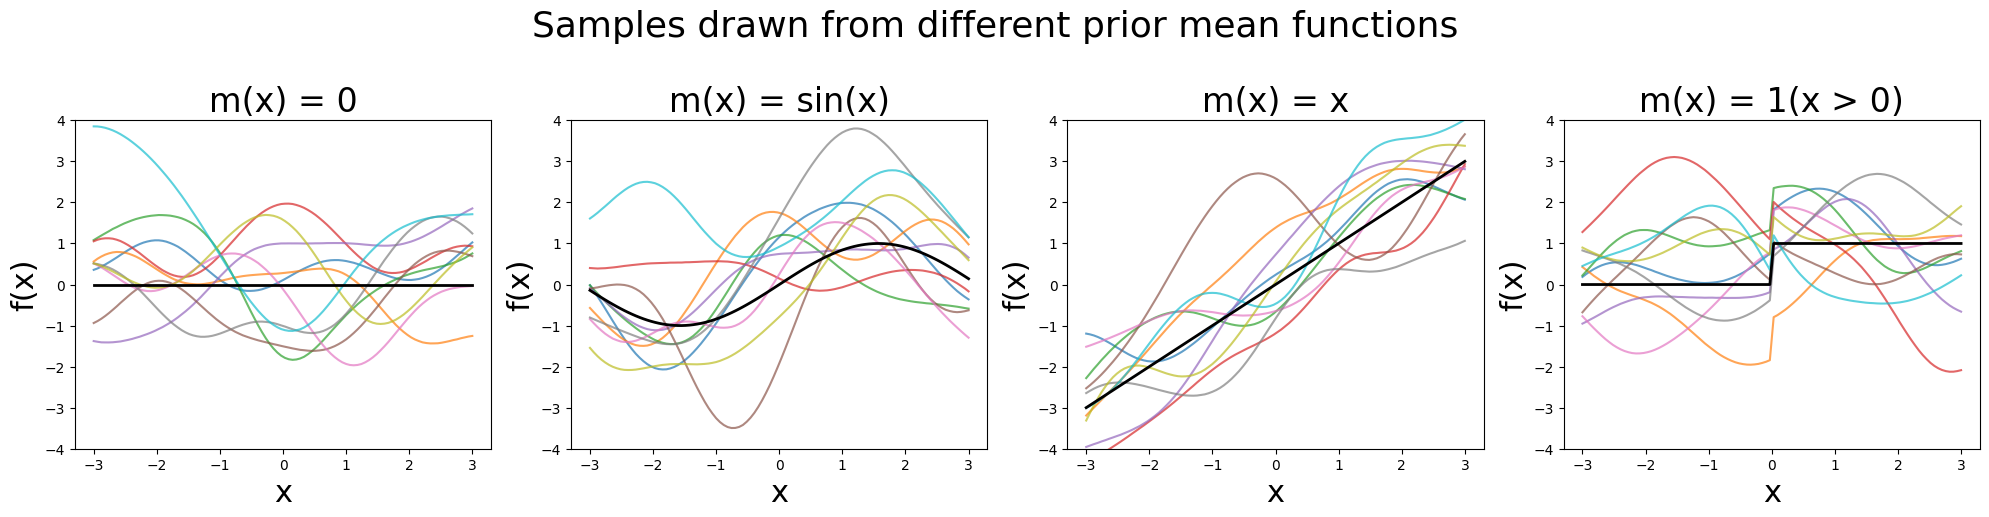

In [6]:
from means import zero_mean, sine_mean,lin_mean, step_mean ## importing mean functions
from kernels import rbf_kernel, lin_kernel, white_kernel, periodic_kernel ## import covariance functions
from visualisations import plot_prior_samples

params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} ## define kernel parameters
mean_functions = [zero_mean, sine_mean, lin_mean, step_mean] ## define mean functions we want to investigate
mean_names = ['0', 'sin(x)', 'x', '1(x > 0)']
plot_prior_samples(mean_functions, mean_names, params, prior_type = "mean", kernel_f = rbf_kernel)

### Prior Covariance function

(kernel cookbook)
The Covariance Function describes in probability theory the change of random variables with varying spatial separation (Wiki). For a stochastic prcess, the covariance function is given by

$$
k(x,x') = E[(Y(x) - \mu(x))(Y(x)-\mu(x))]
$$

For Gaussian Processes, the covariance function has to be symmetric and positive semi-definite to be valid. The most common kernel is the RBF kernel, which models smooth functions but there are many kernel choices with a choice that can be found in the *kernels.py* file which are:

| Kernel Type    | Formula                                                                                             | Description                                                                                         |
|----------------|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| RBF Kernel     | $$ k_{SE}(x,x') = \sigma_{s}^2 \exp\left(\frac{(x-x')^2}{2l^2}\right)  $$ | Radial Basis Function, known as Gaussian kernel which models smooth function behaviour.                                                |
| Periodic Kernel| $$ k_{Per}(x,x') = \sigma_{s}^2 \exp\left(\frac{2 \sin^2(\pi|x-x'|)/p}{l^2}\right)  $$ | Models functions which repeat themselves with periodicity being defined by the additional period parameter $p$                                                          |
| Linear Kernel  | $$ k_{Lin}(x,x') = \sigma_{s}^2 x \cdot x' $$                                                       | Performs Bayesian linear regression, computed as the dot product.                                   |
| White Kernel   | $$ k(x,x') = \sigma_{s}^2 I_{n} $$                                                                  | Models noise only without correlations.                                                                          |


is defined by:
- the characteristic length-scale $l$
- the signal variance $\sigma_{s}^2$
</details>

For all kernels, we add the noise variance $\sigma_{n}$.
$$
k(x,x') = k(x,x*) + \sigma_{n}^2 \delta(x,x')
$$


See [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) for more examples of kernels.


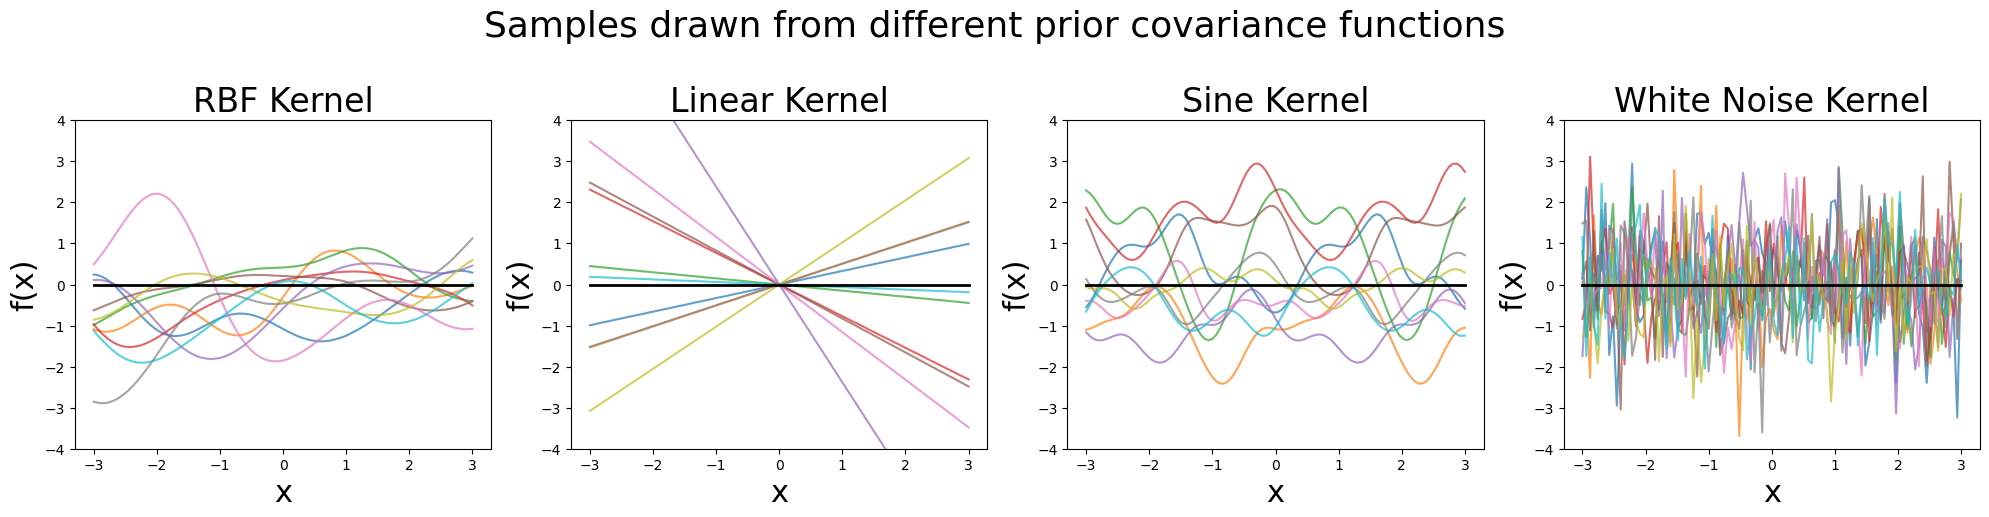

In [7]:
kernel_functions = [rbf_kernel, lin_kernel, periodic_kernel, white_kernel] ## define kernel functions
kernel_names = ['RBF', 'Linear', 'Sine', 'White Noise']
params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} ## define kernel parameters
mean_names = ['0', 'sin(x)', 'x', '1(x > 0)']
plot_prior_samples(kernel_functions, kernel_names, params, prior_type = "covariance", mean_f = zero_mean)

Another choice being done by the modeller is the hyperparameter selection which changes the behaviour of the covariance function and thereby the behaviour of sample functions drawn from the prior GP. In the following visualation, the effect of the lengthscale, signal variance, and noise variance hyperparameters can be explored for different kernels (and the period parameter for the periodic kernel). You can also select different mean functions which changes the function trend, as shown by the black line, visualising the GP prior mean.

In [8]:
from means import mean_dict
from kernels import kernel_dict
from gp_functions import draw_samples
from widgets_helper import varSigma_slider, lengthscale_slider, period_slider, toggle_sliders, noise_slider, create_mean_dropdown, create_cov_dropdown
from visualisations import plot_samples_and_kernels
mean_f = zero_mean

def update(mean_name, kernel_name, varSigma, lengthscale, noise, period):
    params = {'varSigma': varSigma, 'lengthscale': lengthscale, 'noise': noise, 'period': period}
    n_samples = 10
    kernel_f = kernel_dict[kernel_name]
    mean_f = mean_dict[mean_name]
    plot_samples_and_kernels(mean_f, kernel_f, params, 10, k_name=kernel_name)

mean_dropdown = create_mean_dropdown()
kernel_dropdown = create_cov_dropdown()
controls = HBox([VBox([HBox([kernel_dropdown]), HBox([varSigma_slider, lengthscale_slider]), HBox([noise_slider, period_slider])]),mean_dropdown],layout=Layout(align_items='center'))
kernel_dropdown.observe(toggle_sliders, names='value')
toggle_sliders({'new': kernel_dropdown.value})
interactive_plot = interactive(update, mean_name = mean_dropdown ,kernel_name=kernel_dropdown, varSigma=varSigma_slider,
                               lengthscale=lengthscale_slider, noise=noise_slider, period=period_slider)
display(VBox([controls, interactive_plot.children[-1]]))

<div class="alert alert-block alert-info"><b>Plot Details:</b> We can change the Gaussian Process Prior mean and prior covariance function using the dropdown menu. For the covariance function, we can also specify the kernel hyperparameters. The left plot shows different samples drawn from the prior GP, the right plot depicts the covariance matrix. We can see that increasing the lengthscale increases the number of neighboring points on the x-axis. Increasing the signal variance changes the amplitude on the y-axis. Note that decreasing the lengthscale of the RBF kernel produces the white noise kernel where the covariance matrix has zero correlations.

From the interactive plots we can observe that:
* The lengthscale controls the x-axis scaling. Increasing it leads to smoother functions as more data correlations (and neighboring poitns) are considered. When the lengthscale parameter approaches zero, we basically obtain a white noise kernel as no correlations between data are considered (only the diagonal).
* the signal variance controls the y-axis scaling. Increasing this hyperparameter increases the diagonal covariance values/the overall variance magnitude.
* the noise variance controls how noisy the functions are. High noise variance makes the functions more cluttered.
* the period hyperparameter changes the periodicity.

These hyperparameters will be important for fitting a GP to actual data as they change the selection of likely function given the data. Therefore, hyperparameter optimisation, as discussed later, is a useful tool to find the best hyperparameter values for a given dataset.


## GP Operations: Marginalisation and conditioning

Now, as we discussed how to specify a GP prior, we will turn towards the main two GP operations: marginalisation and conditioning. Since Gaussian Processses are a stochastic process where every pair of random variables follows a multivariate Gaussian distribution, the two properties of Gaussian distributions, closure under marginalisation and closure under conditionig also apply here. First, we will look at the conditioning operation.

### Conditioning

Conditioning a GP means updating a GP with new data. Given new data points, a prior GP, as defiend by its mean and covariance function can be rewritten as the posterior GP with a posterior mean and covariance function and the log marginal likelihood which indicates how good the model is.

The conditioning operation adjusts the set of likely functions based on observed data. In practise this means that the GP takes a prior mean and covariance function and data and returns the posterior mean and covariance function and the log marginal likelihood which we will discuss later. The precise algorithmic implementation can be found here:  

<div style="text-align: center;">
<img src="attachment:89345c42-9087-4b28-b4ca-4d90f7476b03.png" width="500"/>
</div>


 As data comes in, we can update the GP which is also called Bayesian online updating



In [9]:
from visualisations import conditional_gps_visualisation
from data import data_1d, f, data_1d_evenly_spaced
from gp_functions import gp_inference, GP_marginal
from widgets_helper import batch_size_dropdown, create_status_label


np.random.seed(42) # random seed for reproducibility
N = 8  # number of training points -> note that increasing training data points will significantly increase the running time for the interactive visualisation
n = 200  # number of test points
noise = 0.001  # noise levels of data

X, y = data_1d(N, noise)
Xtest = np.linspace(-5, 5, n).reshape(-1, 1) # number of test points
ytest = f(Xtest) # ground truth
params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} # defining hyperparameters for kernel


# Define the update function
def update(batch_size, mean_f, cov_f):
    kernel_f = kernel_dict[cov_f]
    mean_f = mean_dict[mean_f]
    conditional_gps_visualisation(batch_size, N, X, y, Xtest, ytest, status_label, mean_f, kernel_f, params)

# Setup the controls and display
mean_dropdown2 = create_mean_dropdown()
kernel_dropdown2 = create_cov_dropdown()
status_label = create_status_label()
controls = VBox([HBox([kernel_dropdown2, mean_dropdown2, batch_size_dropdown, status_label])])
interactive_plot = interactive(update, batch_size=batch_size_dropdown, mean_f=mean_dropdown2, cov_f=kernel_dropdown2)
display(controls)
display(interactive_plot.children[-1])


Output()

<div class="alert alert-block alert-info"><b>Plot Details:</b> Conditioning the GP on the whole data set at once is equivalent to sequentially updating the GP with data batches. The more data we condition on the more the uncertainty reduces around the conditioned data points. Changing the mean becomes especially important for extrapolation, for inputs far away from the data.
</div>

### Marginalisation

When marginalising a GP, contributions of marginalised variables are integrated out. This means that we move from an infinite dimensional object to a finite dimensional object. The marginalisation property is quite handy for this as it states that we just ignore all variables irrelevant for our computation when marginalising which can be expressed as:

<div style="text-align: center;">
<img src="attachment:08cec150-7e72-4da1-873b-7b71733d68eb.png" width="400"/>
</div>



In [22]:
from visualisations import gpr_components_visualisation

def update(mean_name, kernel_name):
    kernel_f = kernel_dict[kernel_name]
    mean_f = mean_dict[mean_name]
    Xtest = np.linspace(-8, 8, 200).reshape(-1, 1)
    mu_f, k_f, _, cov_contribution_f, mean_contribution_f = gp_inference(mean_f, kernel_f, params, X, y, True)
    mu_pred, k2 = GP_marginal(mu_f, k_f, Xtest)
    k_pred = np.sqrt(np.diag(k2))

    prior_cov = kernel_f(Xtest, Xtest, params)
    data_cov = cov_contribution_f(Xtest, Xtest)
    posterior_cov = k_f(Xtest, Xtest, params)
    vmin_cov, vmax_cov = min(prior_cov.min(), data_cov.min(), posterior_cov.min()), max(prior_cov.max(), data_cov.max(), posterior_cov.max())

    prior_mean = mean_f(Xtest).reshape(1,-1)
    data_mean = mean_contribution_f(Xtest).reshape(1,-1)
    posterior_mean = mu_f(Xtest).reshape(1,-1)
    vmin_mean, vmax_mean = min(prior_mean.min(), data_mean.min(), posterior_mean.min()), max(prior_mean.max(), data_mean.max(), posterior_mean.max())

    with output:
        print("UPDATING PLOTS")
        output.clear_output(wait=True)
        with fig.batch_update():
            ## Update GPR plot
            fig.data[0].x, fig.data[0].y = X.flatten(), y
            fig.data[1].x, fig.data[1].y = Xtest.flatten(), mu_pred
            fig.data[2].x = np.concatenate([Xtest.flatten(), Xtest.flatten()[::-1]])
            fig.data[2].y = np.concatenate([mu_pred - 1.96 * k_pred, (mu_pred + 1.96 * k_pred)[::-1]])

            ## Update Heatmaps
            x_vals = Xtest.flatten()
            fig.data[3].z, fig.data[3].x, fig.data[3].y = prior_cov, x_vals, x_vals
            fig.data[4].z, fig.data[4].x, fig.data[4].y = data_cov, x_vals,x_vals
            fig.data[5].z, fig.data[5].x,fig.data[5].y = posterior_cov, x_vals,x_vals
            fig.data[6].z, fig.data[6].x = prior_mean, x_vals
            fig.data[7].z, fig.data[7].x = data_mean, x_vals
            fig.data[8].z, fig.data[8].x = posterior_mean, x_vals
        display(fig)

fig = gpr_components_visualisation()
output = widgets.Output()
mean_dropdown4 = create_mean_dropdown()
kernel_dropdown4 = create_cov_dropdown()

controls = VBox([HBox([kernel_dropdown4, mean_dropdown4], layout=widgets.Layout(margin='10px 0px')), output])

interactive_plot = interactive(update, mean_name=mean_dropdown4, kernel_name=kernel_dropdown4)
update(mean_dropdown4.value, kernel_dropdown4.value)

display(controls)
display(interactive_plot.children[-1])


Output()

<div class="alert alert-block alert-info"><b>Plot Details:</b> Conditioning the GP on the whole data set at once is equivalent to sequentially updating the GP with data batches. The more data we condition on the more the uncertainty reduces around the conditioned data points.
</div>

## Log Marginal Likelihood

For now, we did not discuss the log marginal likelihood in detail. However, it can have several crucial roles in problems, such as hyperparameter optimisation, model evaluation, and model selection which we will discuss now.

### Interpretation of the log marginal likelihood

The analytical solution for the log marginal likelihood is given by:
$$
\log p(\textbf{y}) = -\frac{1}{2} \textbf{y}^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \textbf{y} - \frac{1}{2} \log \det(\mathbf{K} + \sigma_n^2 \mathbf{I}) - \frac{N}{2} \log (2\pi)
$$

To better understand the log marginal likelihood, we can decompose the log marginal likelihood into three terms:
- the data fit term $ -\frac{1}{2} \textbf{y}^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \textbf{y} $
- the complexity term $ - \frac{1}{2} \log \det(\mathbf{K} + \sigma_n^2 \mathbf{I}) $
- the constant term $- \frac{N}{2} \log (2\pi)$
  
Usually, we maximise the log marginal likelihood, thus higher values are better.

In the following plot, we plot the all three components for different length scales. What we can see from that is that there is a trade-off between model complexity and data fit.
- the data fit term for low length scales is better and worsens with higher length scales. Thinking back about the previous plots this is intuitive as lowering the length scale leads to wigglier functions as the GP considers only correlations of the immediate neighboring points. With larger length scales, more correlations and neighboring points are considered which smoothens the function but also worsens the fit as the function gets does not capture. However too low length scales worsen the fit again as too little information from the data is considered.
- the model complexity term on the other hand improves with higher length scales as a higher length scale implies smoother, less complex functions. Mathematically, this can be seen as the complexity term depends on the determinant of the covariance matrix K. A covariance matrix with higher correlations (non-zero off-diagonals), as obtained by low length scales, will naturally imply a lower determinant, worsening the log marginal likelihood. A covariance matrix with mostly zero off-diagonas, as obtained by very high length scales, however increases the determinant, improving the log marginal likelihood.
-
This shows that there is a sweet spot between the data complexity and fit which can be found by hyperparameter optimisation.





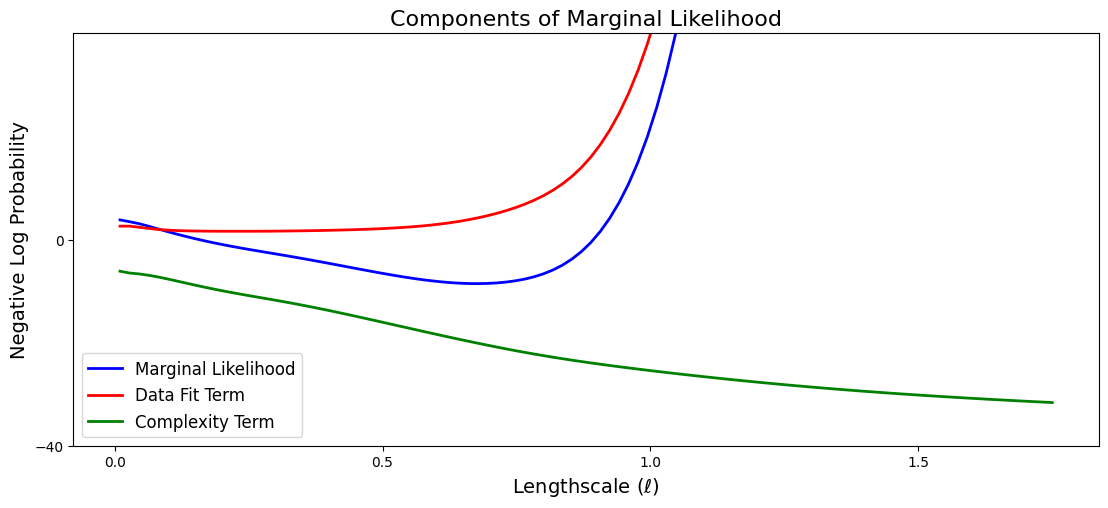

In [11]:
from gp_functions import neg_log_marginal_likelihood
def decompose_marginal_likelihood(lengthscales):
    neg_log_likelihoods, data_fits, complexities = [], [], []
    params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001}  # defining hyperparameters for kernel
    for lengthscale in lengthscales:
        param_keys = list(params.keys())
        current_params = [params['varSigma'], lengthscale, params['noise']]
        neg_log_likelihood, data_fit, complexity, constant_term = neg_log_marginal_likelihood(current_params, param_keys, X, y, zero_mean, rbf_kernel, True)
        neg_log_likelihoods.append(neg_log_likelihood)
        data_fits.append(data_fit)
        complexities.append(complexity)
    return neg_log_likelihoods, data_fits, complexities

lengthscales = np.linspace(0.01, 1.75, 100)
neg_log_likelihoods, data_fits, complexities = decompose_marginal_likelihood(lengthscales)

# Components of log marginal likelihood
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(lengthscales, neg_log_likelihoods, label='Marginal Likelihood', color='blue', linewidth=2)
ax.plot(lengthscales, data_fits, label='Data Fit Term', color='red', linewidth=2)
ax.plot(lengthscales, complexities, label='Complexity Term', color='green', linewidth=2)
ax.set_xlabel(r'Lengthscale ($\ell$)', fontsize = 14)
ax.set_ylabel('Negative Log Probability', fontsize = 14)
ax.legend(loc='lower left', fontsize = 12)
ax.set_ylim([-40, 40])
ax.set_xticks([0, 0.5, 1, 1.5])
ax.set_yticks([-40, 0])
ax.set_title('Components of Marginal Likelihood', fontsize = 16)
fig.tight_layout(pad=4.0)
plt.show()


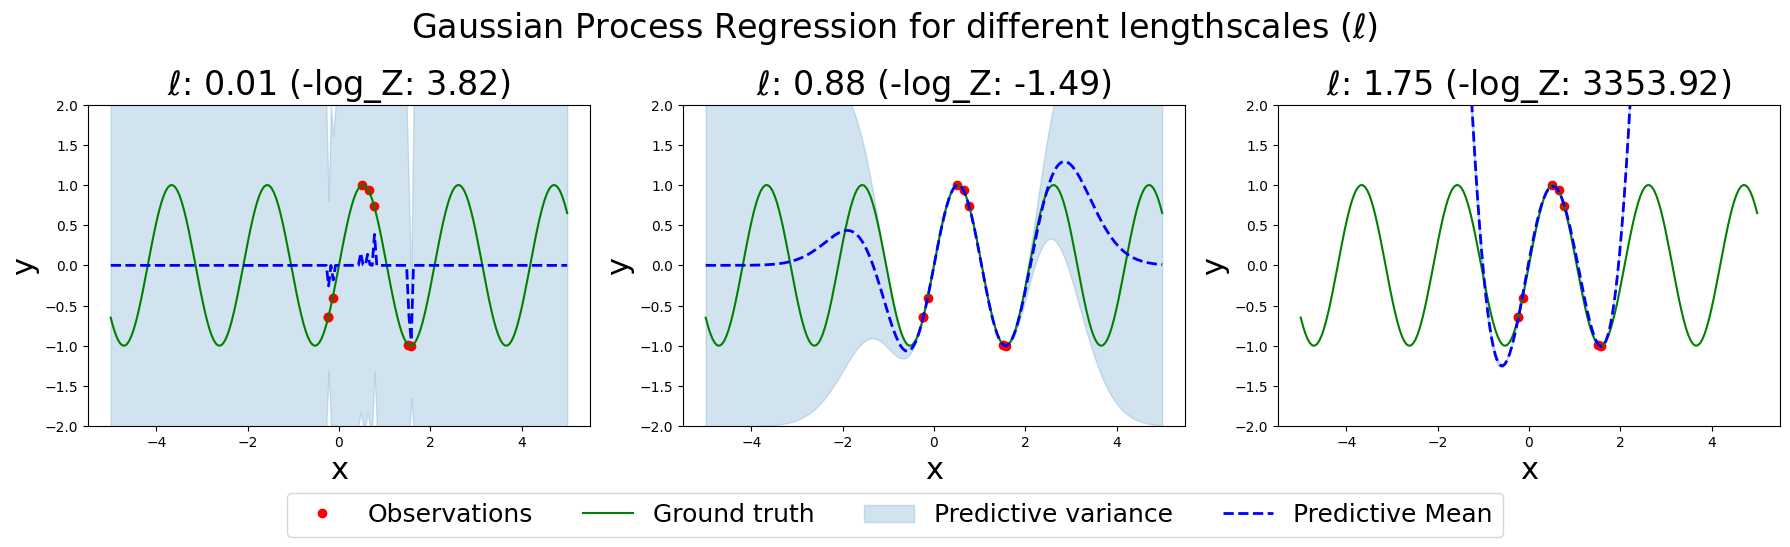

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
lengthscales_to_test = [np.min(lengthscales), np.median(lengthscales), np.max(lengthscales)]
for i, l in enumerate(lengthscales_to_test):
    params["lengthscale"] = l
    mu_f, k_f, log_Z = gp_inference(zero_mean, rbf_kernel, params, X, y, False)
    m, cov = GP_marginal(mu_f, k_f, Xtest)
    k = np.sqrt(np.diag(cov))
    ax[i].plot(X, y, 'ro', label="Observations")
    ax[i].plot(Xtest, ytest, 'g-', label="Ground truth")
    ax[i].fill_between(Xtest.flatten(), m - 2 * k, m + 2 * k, color='#1f77b4', alpha=0.2, label='Predictive variance')
    ax[i].plot(Xtest, m, 'b--', lw=2, label="Predictive Mean")
    ax[i].set_title(r'$\ell$: {:.2f} (-log_Z: {:.2f})'.format(l, log_Z))
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_ylim([-2,2])
fig.suptitle(r'Gaussian Process Regression for different lengthscales ($\ell$)', fontsize = 24)


# Consolidate legends
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize = 18)

plt.tight_layout()
plt.show()

### Negative Log marginal likelihood for Hyperparameter optimisation
As visible from the previous plot, the log marginal likelihood gives an indication of goodness of fit in relation to model complexity. Thus, taking gradient-based methods using the derivatives of the log marginal likelihood with respect to the hyperparameters can be used to find the optimal hyperparameters.

We set the optimal hyperparameters by maximising the marginal likelihood by using the partial derivatives of the marginal likelihood w.r.t. all hyperparameters. For this gradient-based methods are generally used.

$$
\frac{\partial}{\partial \theta_j} \log p(y \mid X, \theta)
= \frac{1}{2} y^\top K^{-1} \frac{\partial K}{\partial \theta_j} K^{-1} y - \frac{1}{2} \operatorname{tr} \left( K^{-1} \frac{\partial K}{\partial \theta_j} \right)
= \frac{1}{2} \operatorname{tr} \left( \alpha \alpha^\top - K^{-1} \right) \frac{\partial K}{\partial \theta_j}
$$

where

$$
\alpha = K^{-1} y.
$$

In practise, there are optimisation packages that automatically calculate the derivatives and use gradient-based methods to find the optimal hyperparameters, such as autograd. By calling gp_inference_optimised and passing a parameter array of initial parameters, the optimised parameters are returned. We plot the 3d contour plots of the log marginal likelihood of each two hyperparameters keeping the third hyperparameter fixed to the optimised value. We minimise the negative log marginal likelihood as this is required by packages such as autorad.



In [13]:
from visualisations import create_figure, compute_log_marginal_likelihood
from gp_functions import gp_inference_optimised

from google.colab import output
output.enable_custom_widget_manager()

np.random.seed(42)
N = 10
n = 200
noise = 0.5
X, y = data_1d(N, noise)
Xtest = np.linspace(-5, 5, n).reshape(-1, 1)
ytest = f(Xtest)
params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.5}
params_copy = params.copy()
mean_f = zero_mean
kernel_f = rbf_kernel

lengthscales = np.linspace(0.0001, 8, 50) # 8
variances = np.linspace(0.3, 6, 50) #0.001 # 0.3
noises = np.linspace(0.2, 0.8, 50) #0.1

# Perform GP inference to find optimized hyperparameters
print(f"Initial hyperparameters: lengthscale: {params_copy['lengthscale']:.2f}, signal variance: {params_copy['varSigma']:.2f}, noise variance: {params_copy['noise']:.2f}")
mu_f, k_f, log_Z = gp_inference_optimised(mean_f, kernel_f, X, y, params_copy)
print(f"Optimized hyperparameters: lengthscale: {params_copy['lengthscale']:.2f}, signal variance: {params_copy['varSigma']:.2f}, noise variance: {params_copy['noise']:.2f}")

# Compute log marginal likelihood surfaces
Z1 = compute_log_marginal_likelihood(lengthscales, variances, 'lengthscale', 'varSigma', params_copy, X, y, zero_mean, rbf_kernel)
Z2 = compute_log_marginal_likelihood(noises, variances, 'noise', 'varSigma', params_copy, X, y, zero_mean, rbf_kernel)
Z3 = compute_log_marginal_likelihood(lengthscales, noises, 'lengthscale', 'noise', params_copy, X, y, zero_mean, rbf_kernel)

fig1 = create_figure(lengthscales, variances, Z1, 'Lengthscale (λ)', 'Signal Variance (σ_f)',
                     f'Negative Log Marginal Likelihood with Noise Variance (σ_n) = {params_copy["noise"]:.2f}')
fig2 = create_figure(noises, variances, Z2, 'Noise Variance (σ_n)', 'Signal Variance (σ_f)',
                     f'Negative Log Marginal Likelihood with Lengthscale (λ) = {params_copy["lengthscale"]:.2f}')
fig3 = create_figure(lengthscales, noises, Z3, 'Lengthscale (λ)', 'Noise Variance (σ_n)',
                     f'Negative Log Marginal Likelihood with Signal Variance (σ_f) = {params_copy["varSigma"]:.2f}')

# Display the figures in tabs
fig1_widget = go.FigureWidget(fig1)
fig2_widget = go.FigureWidget(fig2)
fig3_widget = go.FigureWidget(fig3)

figures = [fig1,fig2,fig3]
sub_tab = [widgets.Output() for i in range(len(figures))]
tab = widgets.Tab(sub_tab)
for i,k in enumerate([r'λ vs σ_f', 'σ_n vs σ_f', 'λ vs σ_n']):
  tab.set_title(i, k)
  with sub_tab[i]:
    figures[i].show()
display(tab)

# tabs = widgets.Tab(children=[fig1_widget, fig2_widget, fig3_widget])
# for i, title in enumerate([r'λ vs σ_f', 'σ_n vs σ_f', 'λ vs σ_n']):
#     tabs.set_title(i, title)

# controls = VBox([tabs])

# display(controls)
# display(fig1_widget)
#display(interactive_plot.children[-1])


# interactive_plot = interactive(update, mean_name=mean_dropdown4, kernel_name=kernel_dropdown4)
# display(controls)
# display(interactive_plot.children[-1])

Initial hyperparameters: lengthscale: 1.00, signal variance: 1.00, noise variance: 0.50
Optimized hyperparameters: lengthscale: 0.46, signal variance: 1.07, noise variance: 0.35


<div class="alert alert-block alert-info"><b>Plot Details:</b> Conditioning the GP on the whole data set at once is equivalent to sequentially updating the GP with data batches. The more data we condition on the more the uncertainty reduces around the conditioned data points.
</div>

By careful inspection, it can be seen that there are two local optima in the first plot (lengthscale vs. signal variance). Depending on the step size and initial hyperparameter settings, different local optima can be found that produce different data interpretations:
- one local optimum consists of a low lengthscale (0.46) and medium high signal variance (1.07), corresponding to a more complex model with larger variance to explain outliers. This is the global optimum.
- the second local optimum has a higher lengthscale (9.8) but lower the signal variance (0.5), corresponding to a simpler model.


## Model selection

After optimising the hyperparameters, one can decide between a discrete set of (optimised models) by comparing the log marginal likelihood. On the final level of Bayesian model selection is the posterior for the model (also called evidence of model)

$$
p(\textbf{y} \mid M_{i}) = \int p(\textbf{y} \mid \textbf(f, M_{i})p(\textbf{f})d\textbf{f}
$$




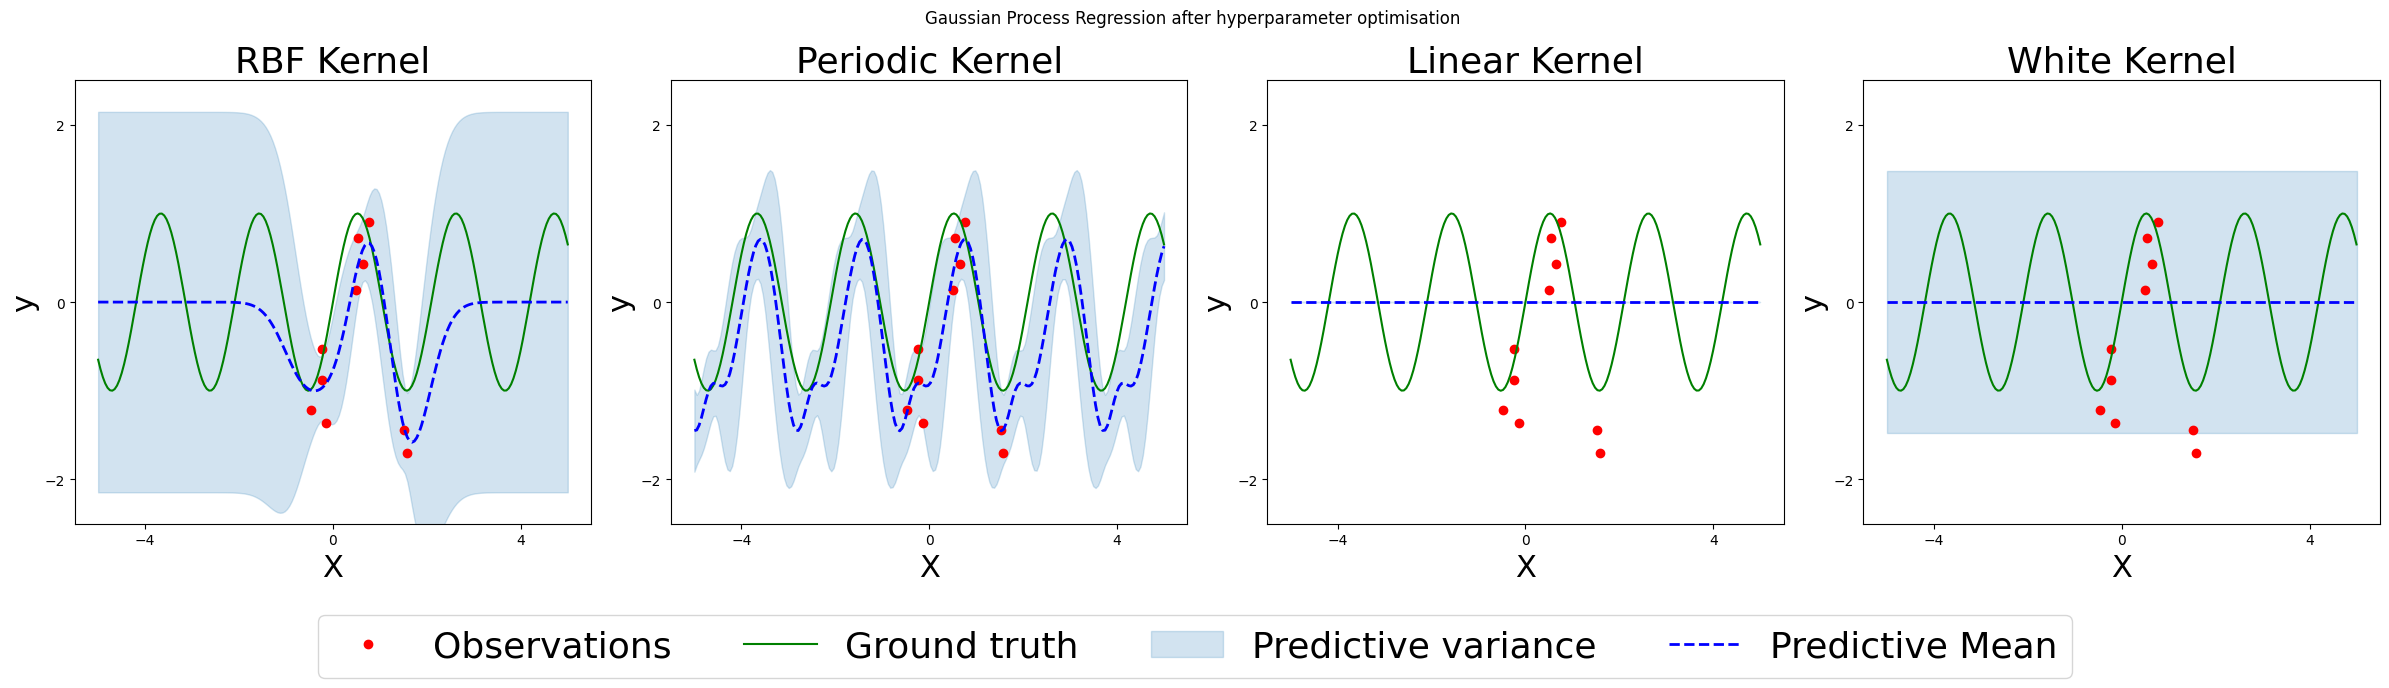

In [14]:
from visualisations import kernel_comparison_gpr
kernels = [rbf_kernel, periodic_kernel, lin_kernel, white_kernel]
kernel_names = ['RBF', 'Periodic', 'Linear', 'White']
mean_function = zero_mean

#LLs_before, params_before = plot_kernels(X, y, Xtest, kernels, optimised=False, showlegend = False)
LLs_after, params_after = kernel_comparison_gpr(X, y, Xtest, ytest, kernels, kernel_names, mean_function, optimised=True, showlegend = True)


In [15]:
from IPython.display import display, HTML
import pandas as pd

# Initial parameters for comparison (same for all kernels as per the setup)
initial_params_dict = {
    'Kernel': 'Initial Parameters',
    'Lengthscale (ℓ)': 1.00,
    'Signal Variance (σf)': 1.00,
    'Noise Variance (σn)': 1.00,
    'Period (p)': 1.00
}

# Create a DataFrame to display the optimized parameters
opt_params = [initial_params_dict]
for i, kernel in enumerate(kernels):
    param_dict = {
        'Kernel': kernel_names[i],
        'Lengthscale (ℓ)': params_after[i].get('lengthscale', '-'),
        'Signal Variance (σf)': params_after[i]['varSigma'],
        'Noise Variance (σn)': params_after[i]['noise'],
        'Period (p)': params_after[i].get('period', '-')
    }
    opt_params.append(param_dict)


# Create a DataFrame for display
df_opt_params = pd.DataFrame(opt_params)
# Rounding the values to two decimal places and handling '-' replacements
df_opt_params = df_opt_params.map(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
df_opt_params.loc[(df_opt_params['Kernel'] != 'Periodic') & (df_opt_params['Kernel'] != 'Initial Parameters'), 'Period (p)'] = '-'
df_opt_params.loc[df_opt_params['Kernel'] == 'White', 'Lengthscale (ℓ)'] = '-'

# Reordering columns and removing index
df_opt_params = df_opt_params[['Kernel', 'Lengthscale (ℓ)', 'Signal Variance (σf)', 'Noise Variance (σn)', 'Period (p)']]
display(HTML("<h3>Optimized Hyperparameters for Each Kernel</h3>"))

display(df_opt_params.style.hide())


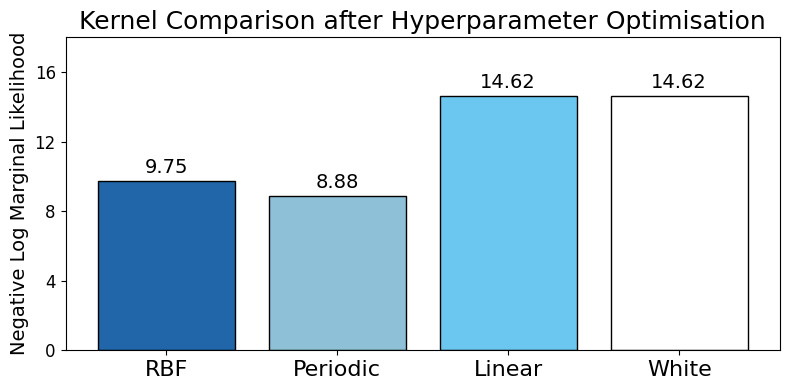

In [16]:
def barplot_kernel_comparison(kernel_names, LLs, title="Model Comparison"):
    bar_colors = ['#2066a8', '#8ec1d8', '#6bc7f0', '#ffffff']
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(kernel_names, LLs, color=bar_colors, edgecolor="black")

    # Set y-axis label and title with specific font sizes
    ax.set_ylabel('Negative Log Marginal Likelihood', fontsize=14)
    ax.set_title(title, fontsize=18)

    # Set x-axis and y-axis ticks with specific font sizes
    ax.tick_params(axis='x', labelsize=16)  # Font size for x-axis (discrete labels)
    ax.tick_params(axis='y', labelsize=12)  # Font size for y-axis

    # Set y-axis ticks
    ax.set_yticks([0, 4, 8, 12, 16])
    ax.set_ylim([0, 18])

    # Annotate the bars with specific font size
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)  # Adjusted fontsize

    plt.tight_layout()
    plt.show()

# Example usage
barplot_kernel_comparison(kernel_names, LLs_after, title="Kernel Comparison after Hyperparameter Optimisation")
